In [1]:
import os
os.chdir('/Users/ngdnh/Codespace/PulsatingPulseShop/')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%config InlineBackend.figure_formats = ['svg']

In [2]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
import utility as ut
import qutip as qt 
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [3]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

print(today)

2025-01-22 08:11:36.311496


# Measurement of $T_1$

In this notebook, I measure the $T_1$ of the transmon qutrit $109$ of the 127-qubit processor IBM Brisbane. 

## The experiment

In [4]:
service = QiskitRuntimeService()
print(service.backends())
backend = service.backend('ibm_brisbane')

qubit = 109
clbit = 0

num_qubits = int(qubit+1)
num_clbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print('Chosen backend', backend)
print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')
print(r'anharmonicity = '+f'{round(qubit_anharmonicty/1e9, 4)}'+' GHz')

[<IBMBackend('ibm_brussels')>, <IBMBackend('ibm_fez')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_strasbourg')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>]
Chosen backend <IBMBackend('ibm_brisbane')>
f01 = 4.985 GHz
f12 = 4.6779 GHz
anharmonicity = -0.3071 GHz


There will be two graphs to plot. From the two graphs, we fit and obtain the relaxation rates $\Gamma_{10}$ and $\Gamma_{21}$. We first outline how we measure $T_1$. It's simple, we excite to $|1\rangle$, and we wait an increasing amount of $\delta t$. As $\delta t$ increases, we expect an exponential decay of the population of the $|1\rangle$ state.

What should be the range of waiting time? The reported $T_1$ ($01$ subpace) by IBM Quantum on qubit 109 is around $90.24\ \mu s$. This means the $|1\rangle$ population decays to $1/2$ after around $90.24\ \mu s$. We therefore should look at the range between 0 and twice this value, $90.24\times 2 = 180.48\ \mu s$. Now, the thing is that we need to convert this into units of `dt`.

In [5]:
dt = backend.configuration().dt

print(dt)

5e-10


We need to wait until...

In [34]:
180.48*1e-6/dt

360959.99999999994

Around 360k dt. That's a very long timescale, compared to a typical pulse length which is 40 dt.

It's also good to check the timing constraints on the interested processor. Here, the resolution of our measurement is limited to 8 dt.

In [35]:
backend.configuration().timing_constraints

{'acquire_alignment': 8,
 'granularity': 8,
 'min_length': 16,
 'pulse_alignment': 8}

In [36]:
start = 8
end = 360008*2
n_elements = 100

delay_time_dt = start + (end - start) * np.exp(-np.linspace(0, 5, n_elements)[::-1])

delay_time_dt = np.array([8 * round(x / 8) for x in delay_time_dt])

print(delay_time_dt)


[  4856   5112   5376   5656   5944   6256   6576   6920   7272   7648
   8048   8464   8904   9360   9848  10360  10896  11456  12048  12672
  13328  14016  14744  15512  16312  17160  18048  18976  19960  20992
  22080  23224  24432  25696  27024  28424  29896  31440  33072  34784
  36584  38480  40472  42568  44776  47096  49536  52096  54800  57640
  60624  63760  67064  70536  74192  78032  82072  86328  90800  95504
 100448 105648 111128 116880 122936 129304 136000 143048 150456 158248
 166448 175064 184136 193672 203704 214256 225360 237032 249304 262224
 275808 290096 305120 320928 337552 355032 373424 392768 413112 434512
 457024 480696 505600 531792 559336 588312 618784 650840 684552 720016]


(array([55., 13.,  8.,  6.,  4.,  3.,  3.,  3.,  2.,  3.]),
 array([  4856.,  76372., 147888., 219404., 290920., 362436., 433952.,
        505468., 576984., 648500., 720016.]),
 <BarContainer object of 10 artists>)

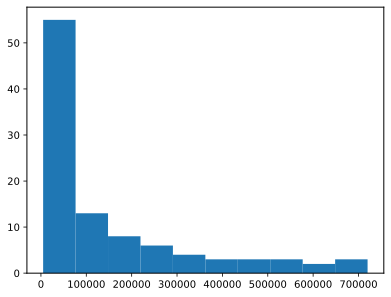

In [37]:
plt.hist(delay_time_dt)

In [38]:
delay = qiskit.circuit.Parameter('delay')

with qiskit.pulse.build(backend=backend) as delay_schedule:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.delay(delay, drive_chan)

delay_gate = qiskit.circuit.Gate("delay", 1, [delay])

The first circuit only excites the qutrit to its $|1\rangle$ state

In [39]:
t1_01_qc = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
t1_01_qc.x(qubit)
t1_01_qc.append(delay_gate, [qubit])
t1_01_qc.measure(qubit, clbit)
t1_01_qc.add_calibration(delay_gate, [qubit], delay_schedule, [delay])

t1_01_circs = [t1_01_qc.assign_parameters({delay: d}, inplace=False) for d in delay_time_dt]

The second circuit excites the qutrit to its $|2\rangle$ state, creating another decay channel, $\Gamma_{21}$. 

In [51]:
with open("./x12_params.json", "r") as json_file:
    x12_params = json.load(json_file)

x12_params

{'freq': 4677855926.141399, 'dur': 40, 'amp': 0.47272727272727266, 'beta': 0}

In [52]:
def pulse12_sched(sx12_params):
    """ 
        Args:
            `amp`: Rabi amplitude
        Return:
            `schedule`: Corresponding schedule for the Rabi 12 pulse with chosen `amp`.
    """
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Drag(duration=sx12_params['dur'], amp=sx12_params['amp'], sigma=int(sx12_params['dur']/4), beta=sx12_params['beta']), drive_chan)
        
    return schedule

In [53]:
pi12_gate = qiskit.circuit.Gate('pi12', 1, [])

t1_012_qc = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
t1_012_qc.x(qubit)
t1_012_qc.append(pi12_gate, [qubit])
t1_012_qc.append(delay_gate, [qubit])
t1_012_qc.measure(qubit, clbit)
t1_012_qc.add_calibration(delay_gate, [qubit], delay_schedule, [delay])
t1_012_qc.add_calibration(pi12_gate, [qubit], pulse12_sched(x12_params))

t1_012_circs = [t1_012_qc.assign_parameters({delay: d}, inplace=False) for d in delay_time_dt]

### Sampler & Job

In [40]:
sampler = Sampler(backend)
num_shots = 5000
 
sampler.options.default_shots = num_shots
sampler.options.execution.meas_type = "kerneled"
sampler.options.execution.rep_delay = 0.0005

In [41]:
t1_01_job = sampler.run(t1_01_circs)
print(t1_01_job.job_id())

cy5we10rta1g00873a50


In [55]:
t1_012_job = sampler.run(t1_012_circs)
print(t1_012_job.job_id())

cy5wyv301rbg008j6grg


In [73]:
print(t1_01_job.status(), t1_012_job.status())

DONE DONE


### Save kerneled data

In [ ]:
t1_job = service.job('cy5tc4rcw2k0008jvzc0')

In [78]:
t1_job_params = {'backend': backend, 'qubit': qubit, 'job_id_string': t1_job.job_id(), 'datetime': datetime.datetime.now(), \
                   'start': start, 'end': end, 'n_elements': n_elements, 'num_shots': num_shots, \
                   'delay_overlap': False, 'mapping_01': False, 'rep_delay': sampler.options.execution.rep_delay, 'extended_delay': 0, 'idling_circuits': False, 'unconditional_reset12': False} 

path = "./characterization/T1/data/" 
folder_name = t1_job_params['job_id_string']
full_path = os.path.join(path, folder_name)

os.mkdir(full_path)

with open(f"./{path}/{t1_job_params['job_id_string']}/params.pkl", "wb") as f:
    pickle.dump(t1_job_params, f)

In [79]:
t1_exp = ut.DataAnalysis(experiment=t1_job, average=False, shots=num_shots, qubit=0)
t1_exp.retrieve_data(average=False)

with open(f"./{path}/{t1_job.job_id()}/iq_data.pkl", "wb") as f:
    pickle.dump(t1_exp.IQ_data, f)

## Data processing

We first process the only-$|1\rangle$-excited experiment.

In [9]:
experiment_id = 'cy5we10rta1g00873a50'

path = f"./characterization/T1/data/{experiment_id}"

iq_data = np.array(np.load(f"{path}/iq_data.pkl", allow_pickle=True))
params = np.load(f"{path}/params.pkl", allow_pickle=True)

params

{'backend': <IBMBackend('ibm_brisbane')>,
 'qubit': 109,
 'job_id_string': 'cy5we10rta1g00873a50',
 'datetime': datetime.datetime(2025, 1, 18, 21, 35, 6, 609733),
 'start': 8,
 'end': 720016,
 'n_elements': 100,
 'num_shots': 5000,
 'delay_overlap': False,
 'mapping_01': False,
 'rep_delay': 0.0005,
 'extended_delay': 0,
 'idling_circuits': False,
 'unconditional_reset12': False}

In [119]:
params['n_elements']

100

We use the discriminator from the `discriminator` experiment.

In [120]:
x0, y0 = -35, 30
x1, y1 = 32, 30
x2, y2 = 22, 6

def discrim(IQpoint):
    d0 = np.sqrt((np.real(IQpoint)-x0)**2+(np.imag(IQpoint)-y0)**2)
    d1 = np.sqrt((np.real(IQpoint)-x1)**2+(np.imag(IQpoint)-y1)**2)
    d2 = np.sqrt((np.real(IQpoint)-x2)**2+(np.imag(IQpoint)-y2)**2)
    lab = {'0': d0, '1': d1, '2': d2}
    smallest_label = min(lab, key=lab.get)
    
    return smallest_label, lab[smallest_label]

In [121]:
pop0 = np.zeros(params['n_elements'])
pop1 = np.zeros(params['n_elements'])
pop2 = np.zeros(params['n_elements'])

for idx in range(params['n_elements']):
    count0, count1, count2 = 0, 0, 0
    for iq_data_point in iq_data[idx]:
        label, _ = discrim(iq_data_point)
        if label == '0':
            count0 += 1
        elif label == '1':
            count1 += 1
        else: 
            count2 += 1
    p0 = count0/params['num_shots']
    p1 = count1/params['num_shots']
    p2 = count2/params['num_shots']
    if (p0+p1+p2-1.0) > 1e-3:
        print('Houston, we have a problem!')
    pop0[idx] = p0
    pop1[idx] = p1
    pop2[idx] = p2

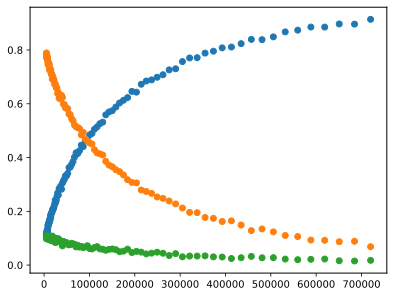

In [122]:
plt.scatter(delay_time_dt, pop0)
plt.scatter(delay_time_dt, pop1)
plt.scatter(delay_time_dt, pop2)

In [123]:
unmitigated_pop = np.stack((pop0, pop1, pop2), axis=1)

confusion_matrix = np.load('./confusion_matrix.npy')

In [124]:
confusion_matrix

array([[0.9771, 0.0184, 0.0045],
       [0.0188, 0.889 , 0.0922],
       [0.0218, 0.1629, 0.8153]])

In [125]:
mitigated_pop = []

for i in range(len(unmitigated_pop)):
    mitigated_pop.append(ut.data_mitigator(unmitigated_pop[i], confusion_matrix))

mitigated_pop = np.array(mitigated_pop)

c:\Users\ngdnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\ngdnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\ngdnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Text(0, 0.5, 'Populations')

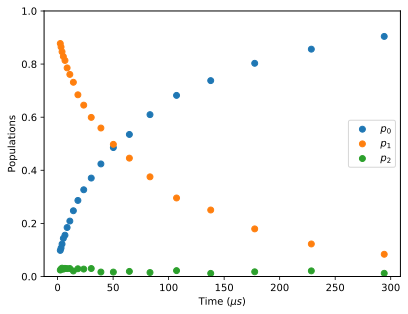

In [127]:
skip = 5

plt.scatter((delay_time_dt[::skip]*dt/1e-6), mitigated_pop[:, 0][::skip], label='$p_0$')
plt.scatter((delay_time_dt[::skip]*dt/1e-6), mitigated_pop[:, 1][::skip], label='$p_1$')
plt.scatter((delay_time_dt[::skip]*dt/1e-6), mitigated_pop[:, 2][::skip], label='$p_2$')

plt.ylim([0, 1])
plt.legend()
plt.xlabel(r'Time ($\mu s$)')
plt.ylabel(r'Populations')

Looking good. We now try to process the also-$|2\rangle$-excited experiment.

In [134]:
experiment_id = 'cy5wyv301rbg008j6grg'

path = f"./characterization/T1/data/{experiment_id}"

iq_data = np.array(np.load(f"{path}/iq_data.pkl", allow_pickle=True))
params = np.load(f"{path}/params.pkl", allow_pickle=True)

params

{'backend': <IBMBackend('ibm_brisbane')>,
 'qubit': 109,
 'job_id_string': 'cy5wyv301rbg008j6grg',
 'datetime': datetime.datetime(2025, 1, 18, 21, 30, 33, 996876),
 'start': 8,
 'end': 720016,
 'n_elements': 100,
 'num_shots': 5000,
 'delay_overlap': False,
 'mapping_01': False,
 'rep_delay': 0.0005,
 'extended_delay': 0,
 'idling_circuits': False,
 'unconditional_reset12': False}

In [135]:
pop0 = np.zeros(params['n_elements'])
pop1 = np.zeros(params['n_elements'])
pop2 = np.zeros(params['n_elements'])

for idx in range(params['n_elements']):
    count0, count1, count2 = 0, 0, 0
    for iq_data_point in iq_data[idx]:
        label, _ = discrim(iq_data_point)
        if label == '0':
            count0 += 1
        elif label == '1':
            count1 += 1
        else: 
            count2 += 1
    p0 = count0/params['num_shots']
    p1 = count1/params['num_shots']
    p2 = count2/params['num_shots']
    if (p0+p1+p2-1.0) > 1e-3:
        print('Houston, we have a problem!')
    pop0[idx] = p0
    pop1[idx] = p1
    pop2[idx] = p2

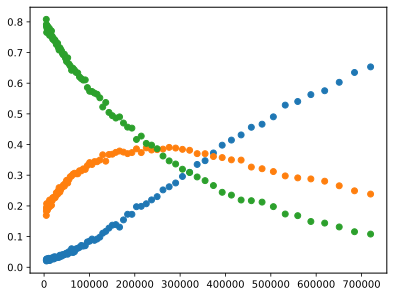

In [136]:
plt.scatter(delay_time_dt, pop0)
plt.scatter(delay_time_dt, pop1)
plt.scatter(delay_time_dt, pop2)

In [137]:
unmitigated_pop = np.stack((pop0, pop1, pop2), axis=1)

confusion_matrix = np.load('./confusion_matrix.npy')

mitigated_pop = []

for i in range(len(unmitigated_pop)):
    mitigated_pop.append(ut.data_mitigator(unmitigated_pop[i], confusion_matrix))

mitigated_pop = np.array(mitigated_pop)

Text(0, 0.5, 'Populations')

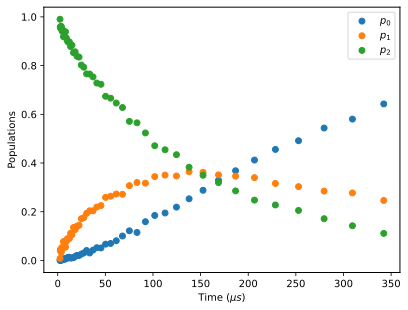

In [138]:
skip = 2

plt.scatter((delay_time_dt[::skip]*dt/1e-6), mitigated_pop[:, 0][::skip], label='$p_0$')
plt.scatter((delay_time_dt[::skip]*dt/1e-6), mitigated_pop[:, 1][::skip], label='$p_1$')
plt.scatter((delay_time_dt[::skip]*dt/1e-6), mitigated_pop[:, 2][::skip], label='$p_2$')

plt.legend()
plt.xlabel(r'Time ($\mu s$)')
plt.ylabel(r'Populations')

In [139]:
delay_time_mu = (delay_time_dt*dt/1e-6)
pop0_t1_012 = mitigated_pop[:, 0]
pop1_t1_012 = mitigated_pop[:, 1]
pop2_t1_012 = mitigated_pop[:, 2]

In [142]:
np.save('./characterization/T1/pop0_t1_012', pop0_t1_012, allow_pickle=True)